<a href="https://colab.research.google.com/github/ucaokylong/chest_xray_pneumonia/blob/main/chest_xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"caoklong","key":"6f7f5764b96c60db861138aba82bd126"}'}

In [5]:
! mkdir ~/.kaggle


In [6]:
! cp kaggle.json ~/.kaggle/



In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets list

ref                                                        title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide              8KB  2023-02-01 12:22:51           9579        317  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                           23KB  2023-02-07 18:42:21           8036        198  1.0              
justin2028/unemployment-in-america-per-us-state            Unemployment in America, Per US State       826KB  2023-03-02 07:26:03            621         42  1.0              
anas123siddiqui/mobiles                                    Mobiles                                      59KB  2023-02-18 16:3

In [12]:
! kaggle competitions download -c 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?fbclid=IwAR2mYI54ID7Tc3GAqouxTNJp7YWUS4CRcfhEwHiltGf6Y7lEVCVywC8IHb0'

403 - Forbidden


In [15]:
! pip install opendatasets
! pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import opendatasets as od
import pandas
  
od.download(
    "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

100%|██████████| 2.29G/2.29G [01:41<00:00, 24.2MB/s]


In [17]:
project_path = "/content/chest-xray-pneumonia"
train_path = project_path + "/chest_xray/train/"
val_path = project_path + "/chest_xray/val/"
test_path = project_path + "/chest_xray/test/"

In [19]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob


In [20]:
from keras.layers import SeparableConv2D
from keras.utils import to_categorical 
from keras.optimizers import Adam
from keras.models import Sequential 
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization
import cv2
from PIL import Image
from pathlib import Path
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,confusion_matrix,classification_report


In [21]:
hyper_dimension = 224
hyper_batch_size = 16
hyper_epochs = 100
hyper_channels = 3
hyper_mode = 'rgb'

## Generate batches of image data (train, validation, and test) with data augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range = 20,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 

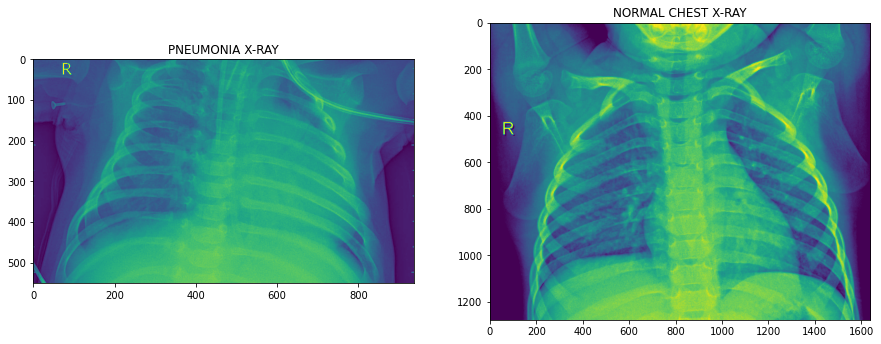

In [22]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
img = glob(train_path+"/PNEUMONIA/*.jpeg") #Getting an image in the PNEUMONIA folder
img = np.asarray(plt.imread(img[0]))
plt.title('PNEUMONIA X-RAY')
plt.imshow(img)

plt.subplot(1 , 2 , 2)
img = glob(train_path+"/NORMAL/*.jpeg") #Getting an image in the NORMAL folder
img = np.asarray(plt.imread(img[0]))
plt.title('NORMAL CHEST X-RAY')
plt.imshow(img)

plt.show()

In [23]:
train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (hyper_dimension, hyper_dimension),
                                                    batch_size = hyper_batch_size, 
                                                    color_mode = hyper_mode,
                                                    class_mode = 'categorical', 
                                                    seed = 42)
val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'categorical',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'categorical',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)

test_generator.reset()

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [24]:
def build_model():
    input_img = keras.layers.Input(shape = train_generator.image_shape, name = "ImageInput")
    x = Conv2D(256, (3,3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(32, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(32, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(2, activation='softmax')(x)
    
    model = Model(inputs = input_img, outputs = output)
    
    return model
    
    

In [30]:
def create_plots(history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [26]:
model= build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 256)     7168      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 256)    1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 256)     590080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 256)    0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 112, 112, 128)    35200 

In [28]:
batch_size = 16
epochs = 40
early_stop = EarlyStopping(patience=25,
                           verbose = 1,
                           monitor='val_loss',
                           mode='auto')

checkpoint = ModelCheckpoint(
    filepath='best_model',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    verbose = 1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=5,
    verbose=1, 
    mode='auto',
    min_delta=0.0001, 
    cooldown=1, 
    min_lr=0.0001
)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(lr=0.0001))

history = model.fit_generator(epochs=epochs,
                              callbacks=[early_stop,checkpoint,reduce],
                              shuffle=True,
                              validation_data=val_generator,
                              generator=train_generator,
                              #steps_per_epoch=500,
                              validation_steps=10,
                              verbose=1)


<ipython-input-28-32ebc71d077b>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(epochs=epochs,


Epoch 1/40
326/326 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.7247


Epoch 1: val_loss improved from inf to 0.69434, saving model to best_model
326/326 [==============================] - 162s 489ms/step - loss: 0.5689 - accuracy: 0.7247 - val_loss: 0.6943 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/40
326/326 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.7339

326/326 [==============================] - 161s 493ms/step - loss: 0.4883 - accuracy: 0.7339 - lr: 1.0000e-04
Epoch 3/40
326/326 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.7360

326/326 [==============================] - 161s 494ms/step - loss: 0.4319 - accuracy: 0.7360 - lr: 1.0000e-04
Epoch 4/40
326/326 [==============================] - ETA: 0s - loss: 0.3971 - accuracy: 0.7368

326/326 [==============================] - 160s 489ms/step - loss: 0.3971 - accuracy: 0.7368 - lr: 1.0000e-04
Epoch 5/40
326/326 [==============================] - ETA: 0s - loss: 0.3657 - accuracy: 0.7379

326/326 [==============================] - 160s 490ms/step - loss: 0.3657 - accuracy: 0.7379 - lr: 1.0000e-04
Epoch 6/40
326/326 [==============================] - ETA: 0s - loss: 0.3926 - accuracy: 0.7404

326/326 [==============================] - 159s 487ms/step - loss: 0.3926 - accuracy: 0.7404 - lr: 1.0000e-04
Epoch 7/40
326/326 [==============================] - ETA: 0s - loss: 0.3646 - accuracy: 0.7396

326/326 [==============================] - 159s 486ms/step - loss: 0.3646 - accuracy: 0.7396 - lr: 1.0000e-04
Epoch 8/40
326/326 [==============================] - ETA: 0s - loss: 0.3674 - accuracy: 0.7389

326/326 [==============================] - 158s 485ms/step - loss: 0.3674 - accuracy: 0.7389 - lr: 1.0000e-04
Epoch 9/40
326/326 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.7822

326/326 [==============================] - 157s 482ms/step - loss: 0.3666 - accuracy: 0.7822 - lr: 1.0000e-04
Epoch 10/40
326/326 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8683

326/326 [==============================] - 159s 485ms/step - loss: 0.3620 - accuracy: 0.8683 - lr: 1.0000e-04
Epoch 11/40
326/326 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8738

326/326 [==============================] - 157s 482ms/step - loss: 0.3517 - accuracy: 0.8738 - lr: 1.0000e-04
Epoch 12/40
326/326 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.8821

326/326 [==============================] - 157s 480ms/step - loss: 0.3353 - accuracy: 0.8821 - lr: 1.0000e-04
Epoch 13/40
326/326 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.8892

326/326 [==============================] - 158s 484ms/step - loss: 0.3512 - accuracy: 0.8892 - lr: 1.0000e-04
Epoch 14/40
326/326 [==============================] - ETA: 0s - loss: 0.3329 - accuracy: 0.8905

326/326 [==============================] - 159s 486ms/step - loss: 0.3329 - accuracy: 0.8905 - lr: 1.0000e-04
Epoch 15/40
326/326 [==============================] - ETA: 0s - loss: 0.3260 - accuracy: 0.8993

326/326 [==============================] - 159s 486ms/step - loss: 0.3260 - accuracy: 0.8993 - lr: 1.0000e-04
Epoch 16/40
326/326 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8917

326/326 [==============================] - 159s 487ms/step - loss: 0.3288 - accuracy: 0.8917 - lr: 1.0000e-04
Epoch 17/40
326/326 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.8907

326/326 [==============================] - 159s 488ms/step - loss: 0.3350 - accuracy: 0.8907 - lr: 1.0000e-04
Epoch 18/40
326/326 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8901

326/326 [==============================] - 160s 490ms/step - loss: 0.3382 - accuracy: 0.8901 - lr: 1.0000e-04
Epoch 19/40
326/326 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.8924

326/326 [==============================] - 158s 485ms/step - loss: 0.3162 - accuracy: 0.8924 - lr: 1.0000e-04
Epoch 20/40
326/326 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.8926

326/326 [==============================] - 160s 491ms/step - loss: 0.3275 - accuracy: 0.8926 - lr: 1.0000e-04
Epoch 21/40
326/326 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.8976

326/326 [==============================] - 161s 492ms/step - loss: 0.3071 - accuracy: 0.8976 - lr: 1.0000e-04
Epoch 22/40
326/326 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.8986

326/326 [==============================] - 159s 487ms/step - loss: 0.3016 - accuracy: 0.8986 - lr: 1.0000e-04
Epoch 23/40
326/326 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.9038

326/326 [==============================] - 160s 491ms/step - loss: 0.3166 - accuracy: 0.9038 - lr: 1.0000e-04
Epoch 24/40
326/326 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.8997

326/326 [==============================] - 159s 487ms/step - loss: 0.3131 - accuracy: 0.8997 - lr: 1.0000e-04
Epoch 25/40
326/326 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8888

326/326 [==============================] - 161s 493ms/step - loss: 0.3121 - accuracy: 0.8888 - lr: 1.0000e-04
Epoch 26/40
326/326 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.8888

326/326 [==============================] - 162s 497ms/step - loss: 0.3136 - accuracy: 0.8888 - lr: 1.0000e-04
Epoch 27/40
326/326 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.8953

326/326 [==============================] - 159s 488ms/step - loss: 0.3143 - accuracy: 0.8953 - lr: 1.0000e-04
Epoch 28/40
326/326 [==============================] - ETA: 0s - loss: 0.3084 - accuracy: 0.8944

326/326 [==============================] - 161s 491ms/step - loss: 0.3084 - accuracy: 0.8944 - lr: 1.0000e-04
Epoch 29/40
326/326 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.9074

326/326 [==============================] - 159s 488ms/step - loss: 0.2805 - accuracy: 0.9074 - lr: 1.0000e-04
Epoch 30/40
326/326 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.9057

326/326 [==============================] - 160s 491ms/step - loss: 0.2762 - accuracy: 0.9057 - lr: 1.0000e-04
Epoch 31/40
326/326 [==============================] - ETA: 0s - loss: 0.2765 - accuracy: 0.9074

326/326 [==============================] - 161s 493ms/step - loss: 0.2765 - accuracy: 0.9074 - lr: 1.0000e-04
Epoch 32/40
326/326 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.9091

326/326 [==============================] - 160s 491ms/step - loss: 0.2848 - accuracy: 0.9091 - lr: 1.0000e-04
Epoch 33/40
326/326 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.9074

326/326 [==============================] - 160s 491ms/step - loss: 0.2780 - accuracy: 0.9074 - lr: 1.0000e-04
Epoch 34/40
326/326 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.9149

326/326 [==============================] - 162s 497ms/step - loss: 0.2683 - accuracy: 0.9149 - lr: 1.0000e-04
Epoch 35/40
326/326 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.9141

326/326 [==============================] - 163s 500ms/step - loss: 0.2710 - accuracy: 0.9141 - lr: 1.0000e-04
Epoch 36/40
326/326 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.9011

326/326 [==============================] - 163s 500ms/step - loss: 0.2820 - accuracy: 0.9011 - lr: 1.0000e-04
Epoch 37/40
326/326 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.9130

326/326 [==============================] - 159s 486ms/step - loss: 0.2747 - accuracy: 0.9130 - lr: 1.0000e-04
Epoch 38/40
326/326 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.9181

326/326 [==============================] - 159s 485ms/step - loss: 0.2695 - accuracy: 0.9181 - lr: 1.0000e-04
Epoch 39/40
326/326 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.9178

326/326 [==============================] - 159s 487ms/step - loss: 0.2675 - accuracy: 0.9178 - lr: 1.0000e-04
Epoch 40/40
326/326 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9271

326/326 [==============================] - 158s 484ms/step - loss: 0.2529 - accuracy: 0.9271 - lr: 1.0000e-04


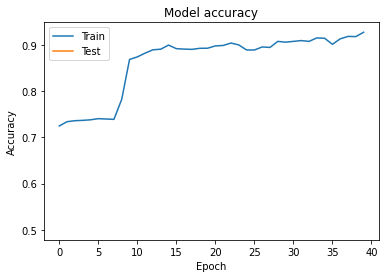

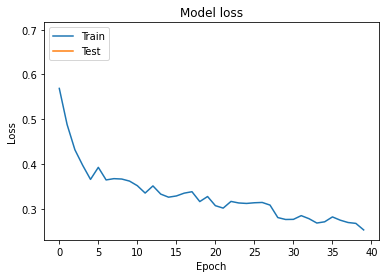

In [31]:
create_plots(history)

In [32]:
test_loss, test_score = model.evaluate_generator(test_generator,steps=100)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

<ipython-input-32-ccf25e512231>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_score = model.evaluate_generator(test_generator,steps=100)


Loss on test set:  0.42689016461372375
Accuracy on test set:  0.8557692170143127


In [34]:
model.save('chest_xray_pneumonia.h5')